In [2]:
import numpy as np
from numpy import ndarray
from typing import Dict,Tuple
import matplotlib.pyplot as plt

In [3]:
def RsS(y_obs:ndarray,y_pred:ndarray)->float:   #Residual Sum of Squares.
    return np.sum(np.power(y_obs-y_pred,2))

def mse(y_obs:ndarray,y_pred:ndarray)->float: #Mean Squared Error.
    return RsS(y_obs,y_pred)/len(y_pred)

def rmse(y_obs:ndarray,y_pred:ndarray)->float: #Root Mean Squared Error.
    return np.sqrt(mse(y_obs,y_pred))

def mae(y_obs:ndarray,y_pred:ndarray)->float:   #Mean Absolute Error
    return np.mean(np.abs(y_obs-y_pred))



In [35]:
def Swth_LaSso(S:ndarray,y:ndarray,weights:Dict[str,ndarray],delta:float = 1.)->Tuple[Dict[str,ndarray],float]:
    assert S.shape[0] == y.shape[0]
    assert S.shape[1] == weights['W'].shape[0]
    
    f1 = np.dot(S,weights['W'])
    f2 = f1 + weights['K']
    f3 = mse(y,f2) + delta*np.sum(np.abs(weights['W']))
    
    forward_info: Dict[str,ndarray] = {}
    forward_info['S'] = S
    forward_info['f1'] = f1
    forward_info['f2'] = f2
    forward_info['delta'] = delta
    forward_info['y'] = y
    
    return forward_info,f3

In [3]:
def permute_data(S:ndarray,w:ndarray):
    perm = np.random.permutation(S.shape[0])
    return S[perm],w[perm]

In [36]:
def grads(forward_info:Dict[str,ndarray],weights:Dict[str,ndarray])->Dict[str,ndarray]:
    S = forward_info['S']
    f2 = forward_info['f2']
    y = forward_info['y']
    delta = forward_info['delta']
    W = weights['W']
    
    grad_W = -2*np.dot(np.transpose(S),(y-f2))/(S.shape[0]) + delta*W/np.abs(W)
    partial_der_K = -2*np.sum(y-f2)
    
    grads:Dict[str,ndarray] = {'W':grad_W,'K':partial_der_K}
        
    return grads

In [8]:
Batch = Tuple[ndarray,ndarray]

def generate_batch(S:ndarray,w:ndarray,start:int = 0, batch_size:int = 100)->Batch:
    assert S.ndim == len(w.shape)
    
    if start + batch_size > S.shape[0]:
        batch_size = S.shape[0] - start
        
    S_batch, w_batch = S[start:start+batch_size],w[start:start+batch_size]
    
    return S_batch, w_batch

In [9]:
def initializing_weights(dim_in:int)->Dict[str,ndarray]:
    W = np.random.randn(dim_in,1)
    K = np.random.randn(1,1)
    
    weights: Dict[str,ndarray] = {'W':W,'K':K}
    
    return weights
    

In [37]:
def train(S:ndarray,y:ndarray,delta:float = 1., n_iter:int = 1000, learning_rate:float = .01,
         batch_size:int = 100, return_losses:bool = False,return_weights:bool = True, seed:int=10)-> None:
    
    if seed:
        np.random.seed(seed)
    start = 0
    
    weights = initializing_weights(S.shape[1])
    
    S,y = permute_data(S,y)
    
    if return_losses:
        losses = []
    for i in range(n_iter):
        
        if start >= S.shape[0]:
            S,y = permute_data(S,y)
            start = 0
        
        S_batch, y_batch = generate_batch(S,y,start,batch_size)
        start += batch_size
        
        forward_info,loss = Swth_LaSso(S,y,weights)
        
        if return_losses:
            losses.append(loss)
        
        loss_grads = grads(forward_info,weights)
        
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
            
    if return_weights:
        return losses,weights
    
    return None
        
    
    
        

In [38]:
def predict(S:ndarray,weights:Dict[str,ndarray]):
    return np.dot(S,weights['W']) + weights['K']

In [14]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [17]:
boston = load_boston()

In [19]:
data = boston.data
target = boston.target

In [20]:
data[:3], target[:3]

(array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
         6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
         1.5300e+01, 3.9690e+02, 4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
         6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
         1.7800e+01, 3.9690e+02, 9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
         7.1850e+00, 6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
         1.7800e+01, 3.9283e+02, 4.0300e+00]]), array([24. , 21.6, 34.7]))

In [21]:
S = StandardScaler()

In [22]:
data = S.fit_transform(data)

In [23]:
data[:3]

array([[-0.41978194,  0.28482986, -1.2879095 , -0.27259857, -0.14421743,
         0.41367189, -0.12001342,  0.1402136 , -0.98284286, -0.66660821,
        -1.45900038,  0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
         0.19427445,  0.36716642,  0.55715988, -0.8678825 , -0.98732948,
        -0.30309415,  0.44105193, -0.49243937],
       [-0.41734159, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
         1.28271368, -0.26581176,  0.55715988, -0.8678825 , -0.98732948,
        -0.30309415,  0.39642699, -1.2087274 ]])

In [24]:
target.shape,target.ndim

((506,), 1)

In [25]:
target  = target.reshape(-1,1)

In [26]:
target.shape,len(target.shape)

((506, 1), 2)

In [27]:
train_data,test_data,train_targets,test_targets = train_test_split(data,target,test_size = .2,random_state= 91221)

In [28]:
train_data[4],test_data[8]

(array([-0.41132859, -0.48772236,  0.24705682, -0.27259857, -1.01668877,
        -0.01657503, -2.22519927,  0.21698572, -0.52300145, -0.06080135,
         0.1130321 ,  0.4193425 , -0.82324949]),
 array([-0.39593474,  0.04877224, -0.47665354, -0.27259857, -0.26515405,
        -0.9312059 ,  1.11749449,  1.08719646, -0.52300145, -0.57751897,
        -1.50523663,  0.32844797,  2.42177359]))

In [40]:
train_info = train(train_data,train_targets,n_iter = 1000,learning_rate = .001,batch_size = 200, return_losses = True,seed =4)

In [41]:
train_info

([591.4885836290958,
  115.14412375978071,
  96.95708637601106,
  95.66827639302932,
  95.0119755168731,
  94.38839018854726,
  93.77520235088183,
  93.17138565489807,
  92.57840863768337,
  92.01353878187966,
  91.45694988382047,
  90.90846093933727,
  90.36789532725021,
  89.8350806964098,
  89.30984886020181,
  88.79203569383613,
  88.28148103418422,
  87.77802858209661,
  87.28600513936551,
  86.81062348385969,
  86.34162410677395,
  85.87887196248879,
  85.42223524937356,
  84.97158532919234,
  84.52679664916441,
  84.08774666597833,
  83.65431577168718,
  83.22638722143809,
  82.80384706299,
  82.3865840679758,
  81.97448966486556,
  81.56745787358832,
  81.16538524177207,
  80.76817078256111,
  80.37571591397217,
  79.98792439975115,
  79.61361135570189,
  79.27345146193025,
  78.93723994612856,
  78.60489833933501,
  78.27635003212852,
  77.95152022707873,
  77.63033589417509,
  77.31272572742468,
  76.99862010252632,
  76.68795103559147,
  76.38065214288608,
  76.0766586015683

In [42]:
weights = train_info[1]

In [43]:
y_pred_train = predict(train_data,weights)

In [44]:
rmse(train_targets,y_pred_train)

5.152346484882051

In [45]:
y_pred_test = predict(test_data,weights)

In [46]:
mse(test_targets,y_pred_test)

29.593792674799264

In [47]:
loss = train_info[0]

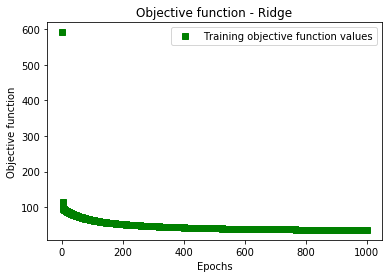

In [57]:
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'gs',label = 'Training objective function values')
plt.title('Objective function - Ridge')
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.legend()